# Tutorial 2. Solving a 1D diffusion equation

In [ ]:

# Document Author: Dr. Vishal Sharma
# Author email: sharma_vishal14@hotmail.com
# License: MIT
# This tutorial is applicable for NAnPack version 1.0.0-alpha4 

### I. Background

The objective of this tutorial is to present the step-by-step solution of a 1D diffusion equation using NAnPack such that users can follow the instructions to learn using this package. The  numerical solution is obtained using the Forward Time Central Spacing (FTCS) method. The detailed description of the FTCS method is presented in Section IV of this tutorial.

### II. Case Description

We will be solving a classical probkem of a suddenly accelerated plate in fluid mechanicas which has the known exact solution. In this problem, the fluid is
bounded between two parallel plates. The upper plate remains stationary and the lower plate is suddenly accelerated in *y*-direction at velocity $U_o$. It is
required to find the velocity profile between the plates for the given initial and boundary conditions.

(For the sake of simplicity in setting up numerical variables, let's assume that the *x*-axis is pointed in the upward direction and *y*-axis is pointed along the horizontal direction as shown in the schematic below:

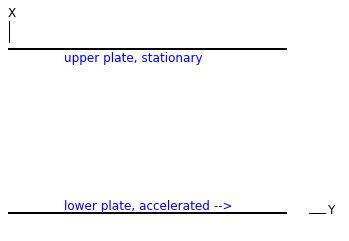

**Initial conditions**
$$u(t=0.0, 0.0<x\leq H) = 0.0 \;m/s$$
$$u(t=0.0, x=0.0) = 40.0 \;m/s$$

**Boundary conditions**
$$u(t\geq0.0, x=0.0) = 40.0 \;m/s$$
$$u(t\geq0.0, x=H) = 0.0 \;m/s$$

Viscosity of fluid, $\;\;\nu = 2.17*10^{-4} \;m^2/s$  
Distance between plates, $\;\;H = 0.04 \;m$  
Grid step size, $\;\;dx = 0.001 \;m$  
Simulation time, $\;\;T = 1.08 \;sec$

Specify the required simulation inputs based on our setup in the configuration file provided with this package. You may choose to save the configuration file with any other filename. I have saved the configuration file in the "input" folder of my project directory such that the relative path is `./input/config.ini`.  

### III. Governing Equation

The governing equation for the given application is the simplified for the the Navies-Stokes equation which is given as:

$$\frac{\partial u} {\partial t} = \nu\frac{\partial^2 u}{\partial x^2}$$

This is the diffusion equation model and is classified as the parabolic PDE.

### IV. FTCS method

The forward time central spacing approximation equation in 1D is presented here. This is a time explicit method which means that one unknown is calculated using the known neighbouring values from the previous time step. Here *i* represents grid point location, *n*+1 is the future time step, and *n* is the current time step.

$$u_{i}^{n+1} = u_{i}^{n} + \frac{\nu\Delta t}{(\Delta x)^2}(u_{i+1}^{n} - 2u_{i}^{n} + u_{i-1}^{n})$$

The order of this approximation is $[(\Delta t), (\Delta x)^2]$

The diffusion number is given as $d_{x} = \nu\frac{\Delta t}{(\Delta x)^2}$ and for one-dimensional applications the stability criteria is $d_{x}\leq\frac{1}{2}$ 

The solution presented here is obtained using a diffusion number = 0.5 (CFL = 0.5 in configuration file). Time step size will be computed using the expression of diffusion number. Beginners are encouraged to try diffusion numbers greater than 0.5 as an exercise after running this script.

Users are encouraged to read my blogs on numerical methods - [link here](https://www.linkedin.com/in/vishalsharmaofficial/detail/recent-activity/posts/).


### V. Script Development

*Please note that this code script is provided in file `./examples/tutorial-02-diffusion-1D-solvers-FTCS.py`.*

As per the Python established coding guidelines [PEP 8](https://www.python.org/dev/peps/pep-0008/#imports), all package imports must be done at the top part of the script in the following sequence -- 
1. import standard library
2. import third party modules
3. import local application/library specific

Accordingly, in our code we will importing the following required modules (in alphabetical order). If you are using Jupyter notebook, hit `Shift + Enter` on each cell after typing the code.

In [2]:
import matplotlib.pyplot as plt
from nanpack.benchmark import ParallelPlateFlow
import nanpack.preprocess as pre
from nanpack.grid import RectangularGrid
from nanpack.parabolicsolvers import FTCS
import nanpack.postprocess as post

As the first step in simulation, we have to tell our script to read the inputs and assign those inputs to the variables/objects that we will use in our entire code. For this purpose, there is a class `RunConfig` in `nanpack.preprocess` module. We will call this class and assign an object (instance) to it so that we can use its member variables. The `RunConfig` class is written in such a manner that its methods get executed as soon as it's instance is created. The users must provide the configuration file path as a parameter to `RunConfig` class.

In [3]:
FileName = "path/to/project/input/config.ini" # specify the correct file path
cfg = pre.RunConfig(FileName) # cfg is an instance of RunConfig class which can be used to access class variables. You may choose any variable in place of cfg.

*******************************************************
*******************************************************
Starting configuration.

Searching for simulation configuration file in path:
"D:/MyProjects/projectroot/nanpack/input/config.ini"
SUCCESS: Configuration file parsing.
Checking whether all sections are included in config file.
Checking section SETUP: Completed.
Checking section DOMAIN: Completed.
Checking section MESH: Completed.
Checking section IC: Completed.
Checking section BC: Completed.
Checking section CONST: Completed.
Checking section STOP: Completed.
Checking section OUTPUT: Completed.
Checking numerical setup.
User inputs in SETUP section check: Completed.
Accessing domain geometry configuration: Completed
Accessing meshing configuration: Completed.
Calculating grid size: Completed.
Assigning COLD-START initial conditions to the dependent term.
Initialization: Completed.
Accessing boundary condition settings: Completed
Accessing constant data: Completed.
Calculatin

You will obtain several configuration messages on your output screen so that you can verify that your inputs are correct and that the configuration is successfully completed. Next step is the assignment of initial conditions and the boundary conditions. For assigning boundary conditions, I have created a function `BC()` which we will be calling in the next cell. I have included this function at the bottom of this tutorial for your reference. It is to be noted that U is the dependent variable that was initialized when we executed the configuration, and thus we will be using `cfg.U` to access the initialized U. In a similar manner, all the inputs provided in the configuration file can be obtained by using configuration class object `cfg.` as the prefix to the variable names. Users are allowed to use any object of their choice.

*If you are using Jupyter Notebook, the function BC must be executed before referencing to it, otherwise, you will get an error. Jump to the bottom of this notebook where you see code cell # 1 containing the `BC()` function*

In [4]:
# Assign initial conditions
cfg.U[0] = 40.0
cfg.U[1:] = 0.0

# Assign boundary conditions
U = BC(cfg.U)

Next, we will be calculating location of all grid points within the domain using the function `RectangularGrid()` and save values into X. We will also require to calculate diffusion number in X direction. In nanpack, the program treats the diffusion number = CFL for 1D applications that we entered in the configuration file, and therefore this step may be skipped, however, it is not the same in two-dimensional applications and therefore to stay consistent and to avoid confusion we will be using the function `DiffusionNumbers()` to compute the term `diffX`.  

In [5]:
X, _ = RectangularGrid(cfg.dX, cfg.iMax)

Uniform rectangular grid generation in cartesian coordinate system: Completed.


In [6]:
diffX,_ = pre.DiffusionNumbers(cfg.Dimension, cfg.diff, cfg.dT, cfg.dX)

Calculating diffusion numbers: Completed.


Next, we will initialize some local variables before start the time stepping:

In [7]:
Error = 1.0 # variable to keep track of error
n = 0 # variable to advance in time

Start time loop using while loop such that if one of the condition returns False, the time stepping will be stopped. For explanation of each line, see the comments. Please note the identation of the codes within the while loop. Take extra care with indentation as Python is very particular about it.

In [8]:
while n <= cfg.nMax and Error > cfg.ConvCrit: # start loop
    Error = 0.0 # reset error to 0.0 at the beginning of each step
    n += 1 # advance the value of n at each step
    Uold = U.copy() # store solution at time level, n
    U = FTCS(Uold, diffX) # solve for U using FTCS method at time level n+1
    Error = post.AbsoluteError(U, Uold) # calculate errors
    U = BC(U) # Update BC
    post.MonitorConvergence(cfg, n, Error) # Use this function to monitor convergence
    post.WriteSolutionToFile(U, n, cfg.nWrite, cfg.nMax,\
                             cfg.OutFileName, cfg.dX) # Write output to file
    post.WriteConvHistToFile(cfg, n, Error) # Write convergence log to history file

   ITER           ERROR
   ----           -----
     10      4.92187500
     20      3.52394104
     30      2.88928896
     40      2.50741375
     50      2.24550338
     60      2.05156084
     70      1.90048503
     80      1.77844060
     90      1.67704721
    100      1.59085792
    110      1.51614304
    120      1.45025226
    130      1.39125374
    140      1.33771501
    150      1.28856146
    160      1.24298016
    170      1.20035213
    180      1.16020337
    190      1.12216882
    200      1.08596559
    210      1.05137298
    220      1.01821734
    230      0.98636083
    240      0.95569280
    250      0.92612336
    260      0.89757851
    270      0.86999638
    280      0.84332454
    290      0.81751777
    300      0.79253655
    310      0.76834575
    320      0.74491380
    330      0.72221190
    340      0.70021355
    350      0.67889409
    360      0.65823042
    370      0.63820074
    380      0.61878436
    390      0.59996158
    400      0.5

In the above convergence monitor, it is worth noting that the solution error is gradually moving towards zero which is what we need to confirm stability in the solution. If the solution becomes unstable, the errors will rise, probably upto the point where your code will crash. As you know that the solution obtained is a time-dependent solution and therefore, we didn't allow the code to run until the convergence is observed. If a steady-state solution is desired, change the STATE key in the configuration file equals to "STEADY" and specify a much larger value of nMax key, say nMax = 5000. This is left as an exercise for the users to obtain a stead-state solution. Also, try running the solution with the larger grid step size, $\Delta x$ or a larger time step size, $\Delta t$.

After the time stepping is completed, save the final results to the output files.

In [9]:
# Write output to file
post.WriteSolutionToFile(U, n, cfg.nWrite, cfg.nMax,
                         cfg.OutFileName, cfg.dX)
# Write convergence history log to a file
post.WriteConvHistToFile(cfg, n, Error)

Verify that the files are saved in the target directory.
Now let us obtain analytical solution of this flow that will help us in validating our codes.

In [10]:
# Obtain analytical solution
Uana = ParallelPlateFlow(40.0, X, cfg.diff, cfg.totTime, 20)

Next, we will validate our results by plotting the results using the matplotlib package that we have imported above. Type the following lines of codes:

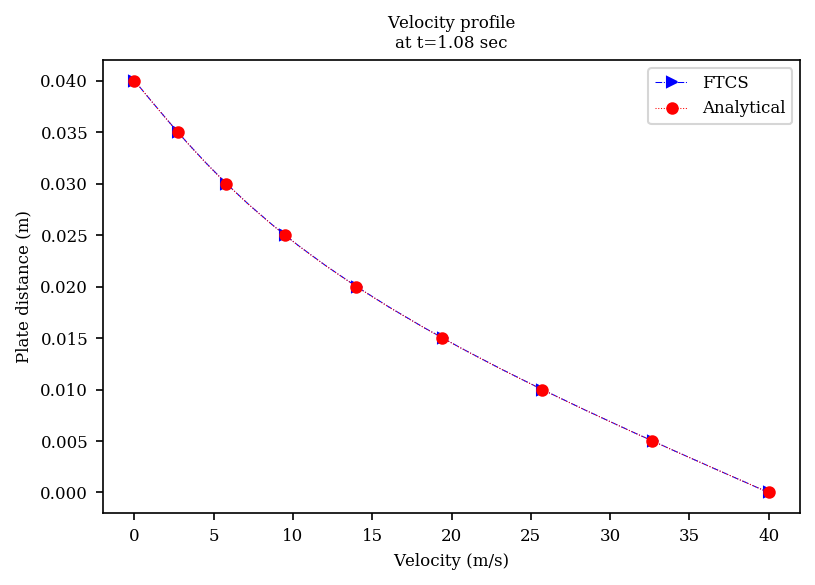

In [11]:
plt.rc("font", family="serif", size=8) # Assign fonts in the plot
fig, ax = plt.subplots(dpi=150) # Create axis for plotting
plt.plot(U, X, ">-.b", linewidth=0.5, label="FTCS",\
         markersize=5, markevery=5) # Plot data with required labels and markers, customize the plot however you may like
plt.plot(Uana, X, "o:r", linewidth=0.5, label="Analytical",\
             markersize=5, markevery=5) # Plot analytical solution on the same plot
plt.xlabel('Velocity (m/s)') # X-axis labelling
plt.ylabel('Plate distance (m)') # Y-axis labelling
plt.title(f"Velocity profile\nat t={cfg.totTime} sec", fontsize=8) # Plot title
plt.legend()
plt.show() # Show plot- this command is very important

Function for the boundary conditions.

In [1]:
def BC(U):
    """Return the dependent variable with the updated values at the boundaries."""
    U[0] = 40.0
    U[-1] = 0.0

    return U

Congratulations, you have completed the first coding tutoria using nanpack package and verified that your codes produced correct results. If you solve some other similar diffusion-1D model example, share it with the nanpack community. I will be excited to see your projects.